**En aquest apartat entrenarem els models a partir dels arrays de numpy exportats a colab per aprofitar la GPU. Les entrades al model són els arrays de imatges preprocessades i les etiquetes corresponents.**




In [11]:
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AveragePooling2D,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Lambda, Activation)
from scipy.stats import mode
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_file_path = '/content/drive/MyDrive/full_mammo_224.zip'

# Ruta de extracción
extract_path = '/content/'

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Arxiu descomprimit a:", extract_path)

Arxiu descomprimit a: /content/


In [4]:
# Importem Tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necessitarem GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

#Keras version is 3.0.5
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.15.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.15.0


### Creem conjunt de dades anotades de mamografies amb contrast


In [5]:
test_images = np.load('/content/test_images.npy')
test_labels = np.load('/content/test_labels.npy')
val_images = np.load('/content/val_images.npy')
val_labels = np.load('/content/val_labels.npy')
train_images = np.load('/content/train_images.npy')
train_labels = np.load('/content/train_labels.npy')

In [6]:
train_images.shape

(3693, 224, 224, 3)

## Creem els tensors de tensorflow a partir dels arrays

In [7]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [24]:
from tensorflow.keras.models import load_model

model_inception = load_model('/content/drive/MyDrive/model_inception1.h5')
model_vgg19 = load_model('/content/drive/MyDrive/model_vgg19_2.h5')
model_effic = load_model('/content/drive/MyDrive/model_effic_2.h5')

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.models import load_model

model_inception = Model(inputs=model_inception.input, outputs=model_inception.layers[-2].output)
model_vgg19 = Model(inputs=model_vgg19.input, outputs=model_vgg19.layers[-2].output)
model_effic = Model(inputs=model_effic.input, outputs=model_effic.layers[-2].output)

model_inception.trainable = False
model_vgg19.trainable = False
model_effic.trainable = False

input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape)

x1 = model_inception(inputs, training=False)
x2 = model_vgg19(inputs, training=False)
x3 = model_effic(inputs, training=False)

x = layers.Concatenate()([x1, x2, x3])

x = layers.Dense(10, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

ensemble_model = Model(inputs=inputs, outputs=outputs)

ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ensemble_model.summary()

ensemble_model.fit(train_ds, epochs=10, validation_data=val_ds)

accuracy = ensemble_model.evaluate(test_ds)
print("Accuracy del model d'ensamblatge:", accuracy)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 144)                  2183828   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 model_1 (Functional)        (None, 1424)                 6456764   ['input_1[0][0]']             
                                                          8                                       
                                                                                            

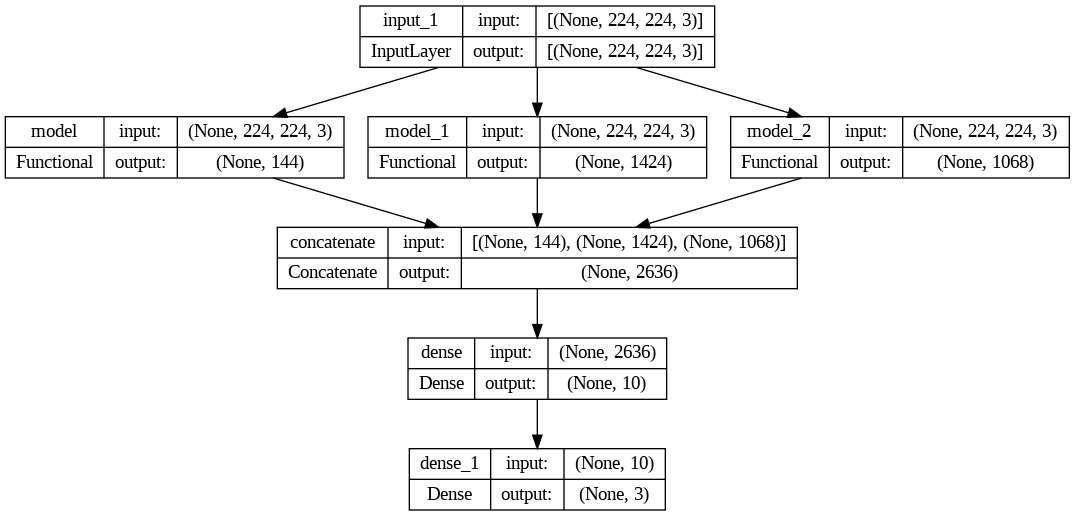

In [12]:
plot_model(ensemble_model, show_shapes=True, to_file='ensemble_model.png')

25/25 [==============================] - 7s 264ms/step


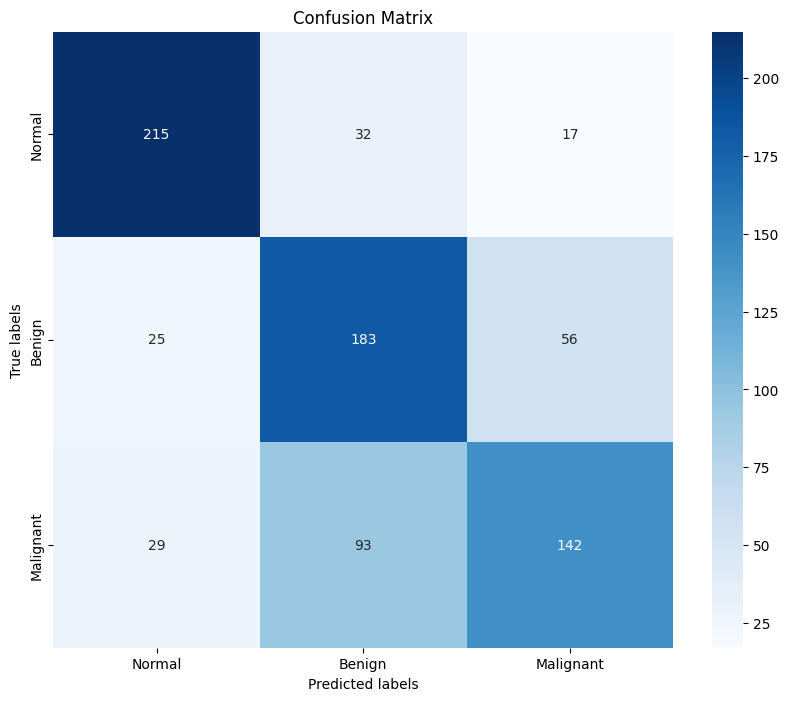

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       264
           1       0.59      0.69      0.64       264
           2       0.66      0.54      0.59       264

    accuracy                           0.68       792
   macro avg       0.68      0.68      0.68       792
weighted avg       0.68      0.68      0.68       792



In [19]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_pred_prob = ensemble_model.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

plot_confusion_matrix(test_labels, y_pred, ('Normal', 'Benign', 'Malignant'))

from sklearn.metrics import classification_report

print(classification_report(test_labels, y_pred))

## Hard voting

In [43]:
preds1 = np.argmax(model_inception.predict(test_ds), axis=1)
preds2 = np.argmax(model_vgg19.predict(test_ds), axis=1)
preds3 = np.argmax(model_effic.predict(test_ds), axis=1)

ensemble_preds = mode(np.array([preds1, preds2, preds3]), axis=0)[0]

accuracy = accuracy_score(test_labels, ensemble_preds)
accuracy

25/25 [==============================] - 2s 76ms/step


0.6742424242424242

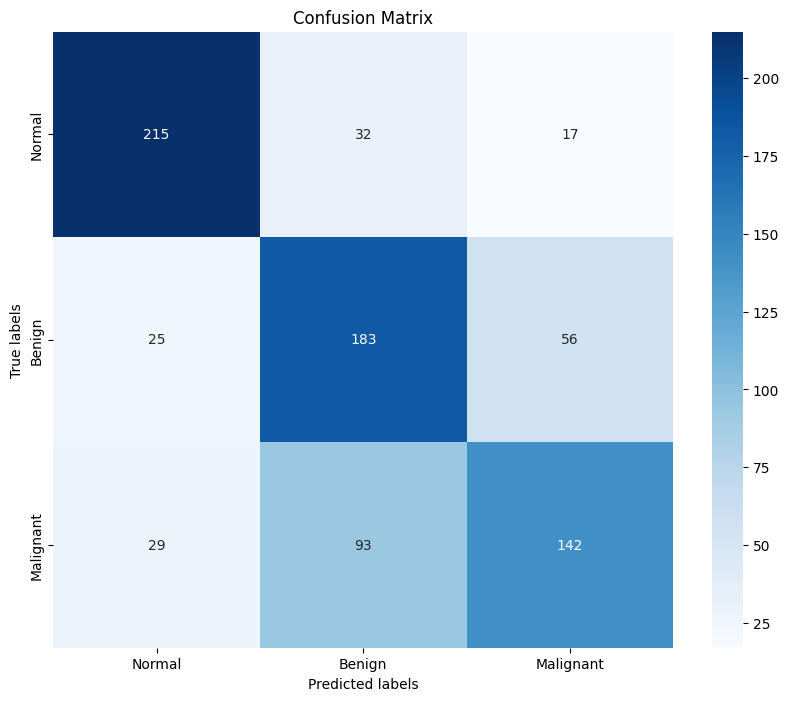

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       264
           1       0.70      0.57      0.63       264
           2       0.62      0.56      0.59       264

    accuracy                           0.67       792
   macro avg       0.67      0.67      0.67       792
weighted avg       0.67      0.67      0.67       792



In [44]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(test_labels, y_pred, ('Normal', 'Benign', 'Malignant'))

from sklearn.metrics import classification_report

print(classification_report(test_labels, ensemble_preds))

## Average voting

In [45]:
probs1 = model_inception.predict(test_ds)
probs2 = model_vgg19.predict(test_ds)
probs3 = model_effic.predict(test_ds)

avg_probs = (probs1 + probs2 + probs3) / 3

ensemble_preds = np.argmax(avg_probs, axis=1)

accuracy2 = accuracy_score(test_labels, ensemble_preds)
accuracy2

25/25 [==============================] - 2s 76ms/step


0.6742424242424242

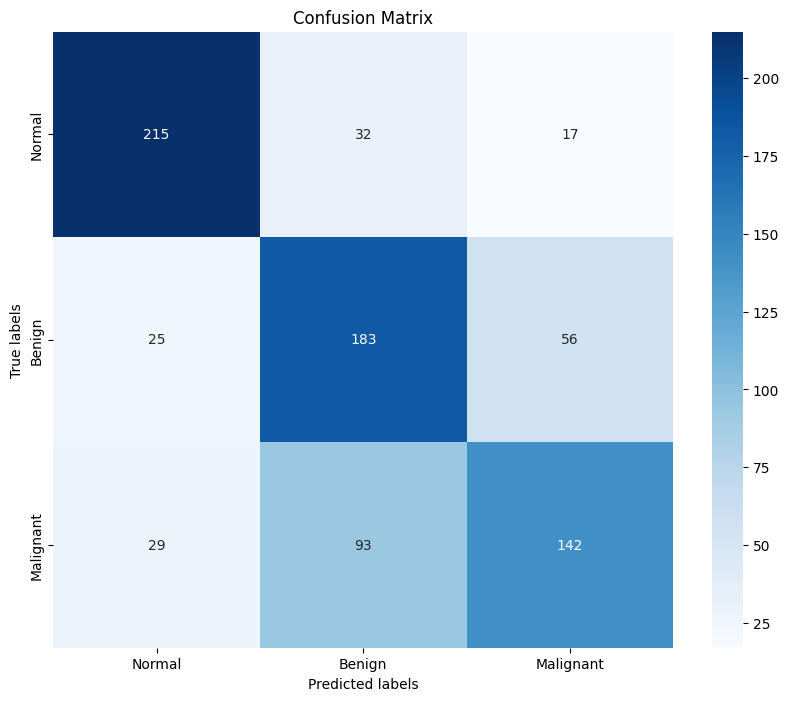

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       264
           1       0.64      0.60      0.62       264
           2       0.61      0.56      0.58       264

    accuracy                           0.67       792
   macro avg       0.67      0.67      0.67       792
weighted avg       0.67      0.67      0.67       792



In [46]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(test_labels, y_pred, ('Normal', 'Benign', 'Malignant'))

from sklearn.metrics import classification_report

print(classification_report(test_labels, ensemble_preds))

## Weighted

In [47]:
def get_class_precisions(model, dataset):
    preds = np.argmax(model.predict(dataset), axis=1)
    true_labels = np.concatenate([y for x, y in dataset], axis=0)
    precisions = f1_score(true_labels, preds, average=None)
    return precisions

precisions_model1 = get_class_precisions(model_inception, val_ds)
precisions_model2 = get_class_precisions(model_vgg19, val_ds)
precisions_model3 = get_class_precisions(model_effic, val_ds)

probs1 = model_inception.predict(test_ds)
probs2 = model_vgg19.predict(test_ds)
probs3 = model_effic.predict(test_ds)

weighted_avg_probs = np.zeros(probs1.shape)
for i in range(probs1.shape[1]):
    weighted_avg_probs[:, i] = (probs1[:, i] * precisions_model1[i] +
                                probs2[:, i] * precisions_model2[i] +
                                probs3[:, i] * precisions_model3[i]) / (
                                precisions_model1[i] + precisions_model2[i] + precisions_model3[i])


ensemble_preds = np.argmax(weighted_avg_probs, axis=1)

accuracy3 = accuracy_score(test_labels, ensemble_preds)
print(accuracy3)


25/25 [==============================] - 2s 76ms/step
0.6767676767676768


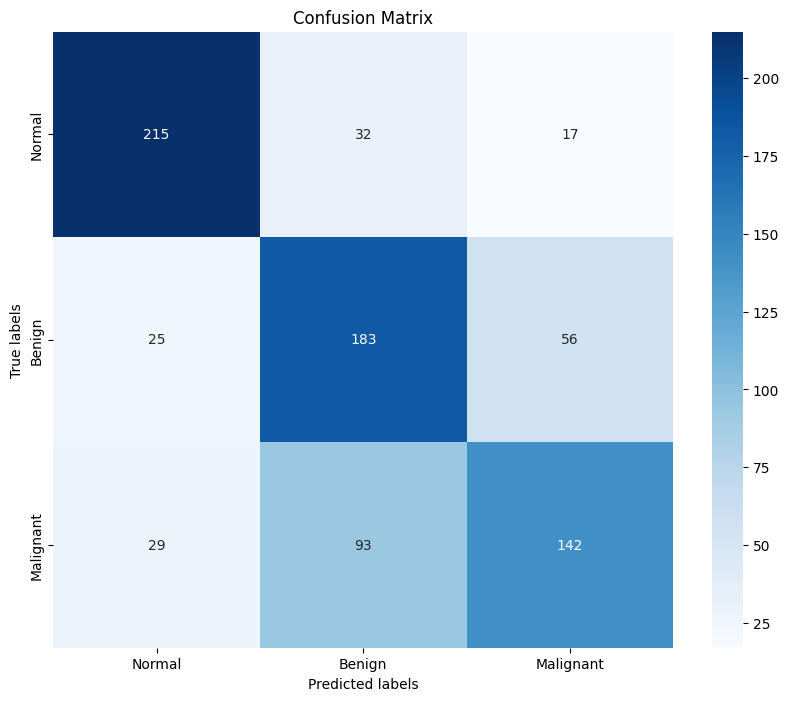

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       264
           1       0.65      0.60      0.62       264
           2       0.61      0.56      0.58       264

    accuracy                           0.68       792
   macro avg       0.67      0.68      0.67       792
weighted avg       0.67      0.68      0.67       792



In [48]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(test_labels, y_pred, ('Normal', 'Benign', 'Malignant'))

from sklearn.metrics import classification_report

print(classification_report(test_labels, ensemble_preds))